In [1]:
# Import library
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from matplotlib.patches import ConnectionPatch
from phreeqpy.iphreeqc.phreeqc_dll import IPhreeqc  # type: ignore

In [2]:
# Create an instance of Iphreeqc
iphreeqc = IPhreeqc()

# Load the Phreeqc database
database_path = "/usr/local/share/doc/IPhreeqc/database/llnl.dat"
print(f"Trying to load the PHREEQC database: {database_path}")
try:
    iphreeqc.load_database(database_path)
    print("Successfully Loaded the PHREEQC database")
except Exception as e:
    print("Failed to Load the PHREEQC database:", e)
    exit(1)

Trying to load the PHREEQC database: /usr/local/share/doc/IPhreeqc/database/llnl.dat
Successfully Loaded the PHREEQC database


In [3]:
# Define input data

Na_molar_mass = 22.9898
Cl_molar_mass = 35.453
Ca_molar_mass = 40.078
K_molar_mass = 39.0983
Mg_molar_mass = 24.305
Si_molar_mass = 28.0855
SO4_molar_mass = 96.06
HCO3_molar_mass = 61.016

pH_input = 8.5
temp_input = 25  # Celcius
Na_input = 8.94  # ppm
Cl_input = 10  # ppm
Ca_input = 25.6  # ppm
K_input = 1.71  # ppm
Mg_input = 8.10  # ppm
Si_input = 4.50  # ppm
SO4_input = 21.1  # ppm
ALK_input = 1.64 # meg/L
Lake_volume = 2.335e+12 # L
River_inflow = 2.6e+11 # L/yr
Simulation_time = 3000 # years

current_input = {
    "pH": pH_input,
    "Na+": Na_input / Na_molar_mass,  # Convert to mmol/kgw
    "Cl-": Cl_input / Cl_molar_mass,  # Convert to mmol/kgw
    "Ca+2": Ca_input / Ca_molar_mass,  # Convert to mmol/kgw
    "K+": K_input / K_molar_mass,  # Convert to mmol/kgw
    "Mg+2": Mg_input / Mg_molar_mass,  # Convert to mmol/kgw
    "Si": Si_input / Si_molar_mass,  # Convert to mmol/kgw
    "SO4-2": SO4_input / SO4_molar_mass,  # Convert to mmol/kgw
    "ALK": ALK_input, # mmol/kgw
    'Temp': temp_input, # Celcius
    'Fugacity': 0, # CO2 Fugacity
    'MHC': 0,
    'AMC': 0,
    'MSH': 0,
    'Gypsum': 0
}

In [4]:
# Fugacity calculation
fug_calc = f"""

SOLUTION 1 # Lake water
    pH      {current_input['pH']}
    temp    {current_input['Temp']} # degrees Celsius
    -water  1 # kg
    density 1.0 # g/cm^3
    units   mmol/kgw
    Na      {current_input['Na+']} 
    Ca      {current_input['Ca+2']}
    K       {current_input['K+']}
    Mg      {current_input['Mg+2']}
    Si      {current_input['Si']}
    S(6)    {current_input['SO4-2']}
    Cl      {current_input['Cl-']} charge
    Alkalinity {current_input['ALK']} as HCO3

SELECTED_OUTPUT
    -file                 false
    -high_precision       false
    -reset                false
    -step                 false
    -pH                   false
    -alkalinity           false
    -water                false
    -saturation_indices   CO2(g)

"""

# Run the PHREEQC
print("Calculating fugacity...")
try:
    iphreeqc.run_string(fug_calc)
except Exception as e:
    print("Failed to execute PHREEQC:", e)

fug_output = iphreeqc.get_selected_output_array()
fug_str = fug_output[1][0]
current_input['Fugacity'] = float(fug_str)

Calculating fugacity...


In [5]:
# Evaporation simulation (No inflow)
no_inflow_calc = f"""

SOLUTION 1 # Lake water
    pH      {pH_input}
    temp    {temp_input} # degrees Celsius
    -water  1 # kg
    density 1.0 # g/cm^3
    units   mmol/kgw
    Na      {Na_input / Na_molar_mass} 
    Ca      {Ca_input / Ca_molar_mass}
    K       {K_input / K_molar_mass}
    Mg      {Mg_input / Mg_molar_mass}
    Si      {Si_input / Si_molar_mass}
    S(6)    {SO4_input / SO4_molar_mass}
    Cl      {Cl_input / Cl_molar_mass} charge
    Alkalinity {ALK_input} as HCO3

PHASES
Monohydrocalcite
    CaCO3:H2O + H+ = Ca+2 + H2O + HCO3-
    log_k     3.1488
AMC_TK
    MgCO3:3H2O + H+ = 3H2O + HCO3- + Mg+2
    log_k     4.7388
MSH075KF
    Mg0.75SiO4H2.5 + 1.5H+ = 2H2O + SiO2 + 0.75Mg+2
    log_k     6.841

REACTION 1 # Evaporation of inflow water
    H2O        -1
    55.505 moles in 500 steps

EQUILIBRIUM_PHASES 1
    CO2(g)    {current_input['Fugacity']} 10
    Monohydrocalcite 0 0
    AMC_TK    0 0
    MSH075KF  0 0

SELECTED_OUTPUT
    -file                 false
    -high_precision       false
    -reset                true
    -step                 true
    -pH                   true
    -alkalinity           true
    -water                true
    -totals               Na  Ca  S(6)  C(4) K Si Mg Cl
    -equilibrium_phases   AMC_TK  Monohydrocalcite  MSH075KF
    -saturation_indices   AMC_TK  Monohydrocalcite  MSH075KF
    -activities           Na+ Ca+2 K+ Mg+2 HCO3- Cl- SO4-2 Si
    -molalities           Na+ Ca+2 K+ Mg+2 HCO3- Cl- SO4-2 Si
    -gases                CO2(g)

"""

In [6]:
# Result

result = []

# Loop
for i in range(0, Simulation_time):

    # Evaporation simulation
    evap_calc = f"""

    PHASES
    Monohydrocalcite
        CaCO3:H2O + H+ = Ca+2 + H2O + HCO3-
        log_k     3.1488
    AMC_TK
        MgCO3:3H2O + H+ = 3H2O + HCO3- + Mg+2
        log_k     4.7388
    MSH075KF
        Mg0.75SiO4H2.5 + 1.5H+ = 2H2O + SiO2 + 0.75Mg+2
        log_k     6.841
    Gypsum

    SOLUTION 1 # Lake water
        pH      {current_input['pH']}
        temp    {current_input['Temp']} # degrees Celsius
        -water  1 # kg
        density 1.0 # g/cm^3
        units   mmol/kgw
        Na      {current_input['Na+']} 
        Ca      {current_input['Ca+2']}
        K       {current_input['K+']}
        Mg      {current_input['Mg+2']}
        Si      {current_input['Si']}
        S(6)    {current_input['SO4-2']}
        Cl      {current_input['Cl-']} charge
        Alkalinity {current_input['ALK']} as HCO3

    SOLUTION 2 # River water
        pH      {pH_input}
        temp    {temp_input} # degrees Celsius
        -water  {River_inflow / Lake_volume} # kg
        density 1.0 # g/cm^3
        units   mmol/kgw
        Na      {Na_input / Na_molar_mass} 
        Ca      {Ca_input / Ca_molar_mass}
        K       {K_input / K_molar_mass}
        Mg      {Mg_input / Mg_molar_mass}
        Si      {Si_input / Si_molar_mass}
        S(6)    {SO4_input / SO4_molar_mass}
        Cl      {Cl_input / Cl_molar_mass} charge
        Alkalinity {ALK_input} as HCO3

    MIX 3
        1   1
        2   1

    REACTION 3 # Evaporation of inflow water
        H2O        -1
        {River_inflow * 55.525397 / Lake_volume} moles in 1 steps

    EQUILIBRIUM_PHASES 3
        CO2(g)    {current_input['Fugacity']} 10
        Monohydrocalcite 0 {current_input['MHC']}
        AMC_TK    0 {current_input['AMC']}
        MSH075KF  0 {current_input['MSH']}
        Gypsum    0 {current_input['Gypsum']}

    SELECTED_OUTPUT
        -file                 false
        -high_precision       false
        -reset                true
        -step                 false
        -pH                   true
        -state                false
        -time                 false
        -distance             false
        -reaction             false
        -simulation           false
        -solution             false
        -alkalinity           true
        -water                true
        -totals               Na  Ca  S(6)  C(4) K Si Mg Cl
        -equilibrium_phases   AMC_TK  Monohydrocalcite  MSH075KF Gypsum
        -saturation_indices   AMC_TK  Monohydrocalcite  MSH075KF Gypsum
        -activities           Na+ Ca+2 K+ Mg+2 HCO3- Cl- SO4-2 Si CO3-2
        -molalities           Na+ Ca+2 K+ Mg+2 HCO3- Cl- SO4-2 Si CO3-2

    """

    # Run the PHREEQC
    print(f"Simulation ({i + 1}/{Simulation_time})", end='\r', flush=True)
    try:
        iphreeqc.run_string(evap_calc)
    except Exception as e:
        print("Failed to execute PHREEQC:", e)
        break

    # Output
    evap_output = iphreeqc.get_selected_output_array()
    evap_header = ['time', *evap_output[0]]
    evap_result = [i + 1, *evap_output[-1]]
    result.append(evap_result)

    # Result feedback
    values = dict(zip(evap_header, evap_result))
    current_input['Na+'] = values.get("Na(mol/kgw)") * 1000
    current_input["Cl-"] = values.get("Cl(mol/kgw)") * 1000
    current_input["Ca+2"] = values.get("Ca(mol/kgw)") * 1000
    current_input["K+"] = values.get("K(mol/kgw)") * 1000
    current_input["Mg+2"] = values.get("Mg(mol/kgw)") * 1000
    current_input["Si"] = values.get("Si(mol/kgw)") * 1000
    current_input["SO4-2"] = values.get("S(6)(mol/kgw)") * 1000
    current_input["ALK"] = values.get("Alk(eq/kgw)") * 1000
    current_input["pH"] = values.get("pH")
    current_input["MHC"] = values.get("Monohydrocalcite")
    current_input["MSH"] = values.get("MSH075KF")
    current_input["AMC"] = values.get("AMC_TK")
    current_input["Gypsum"] = values.get("Gypsum")


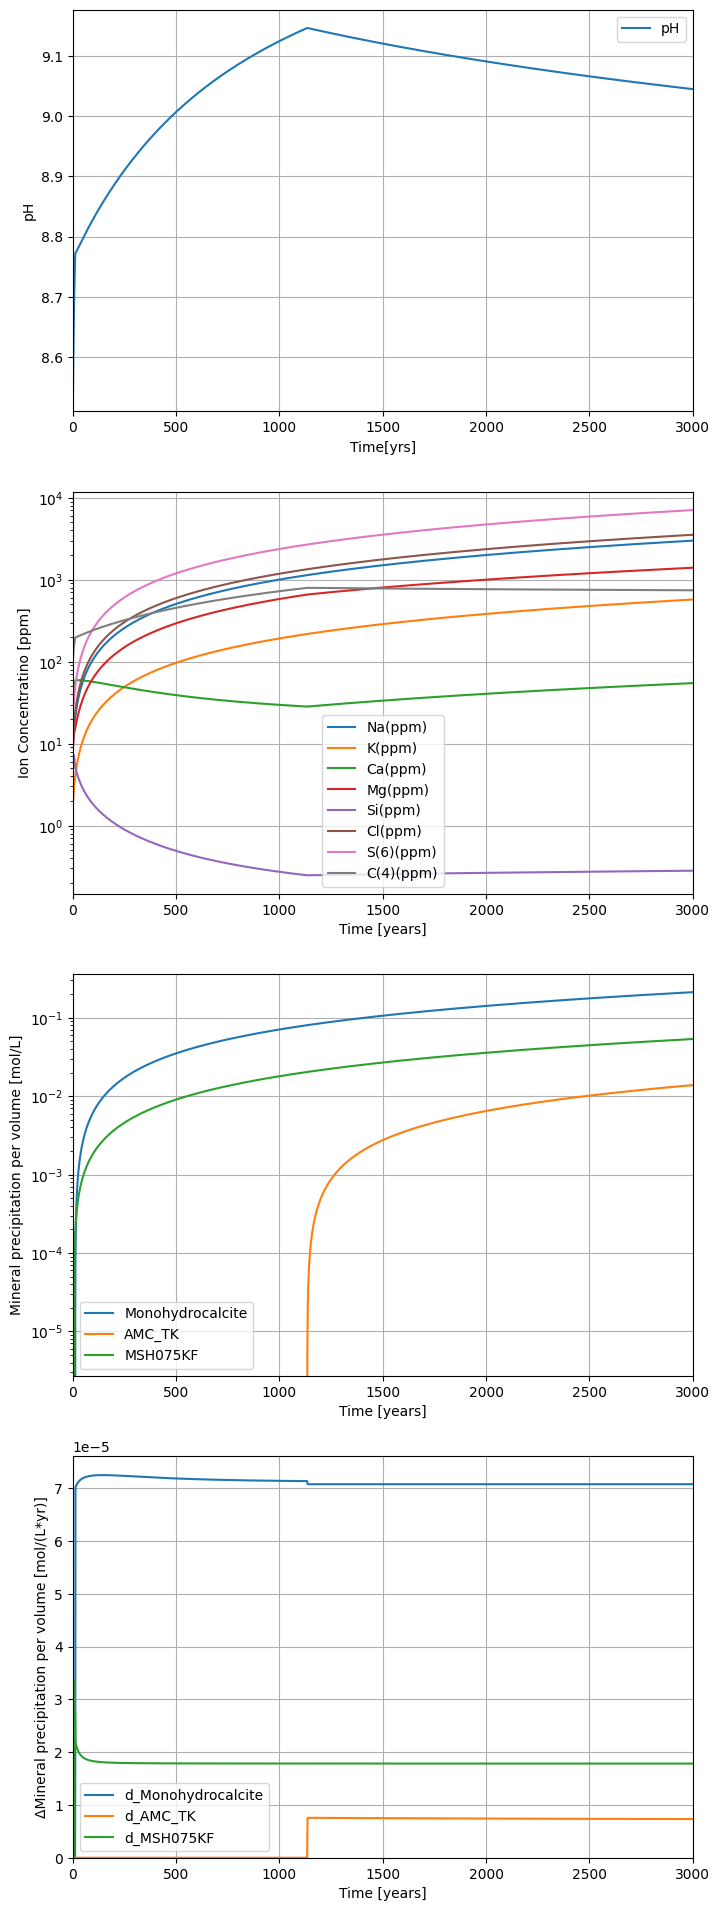

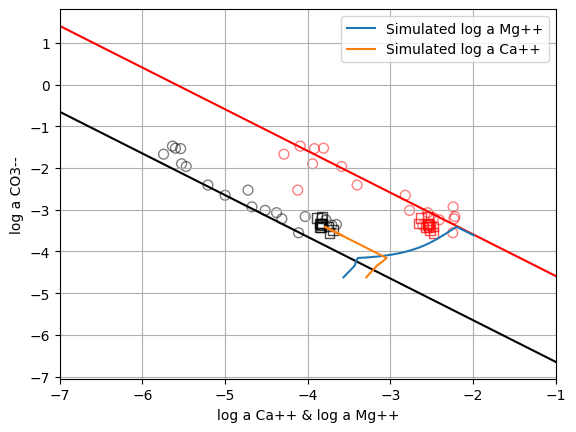

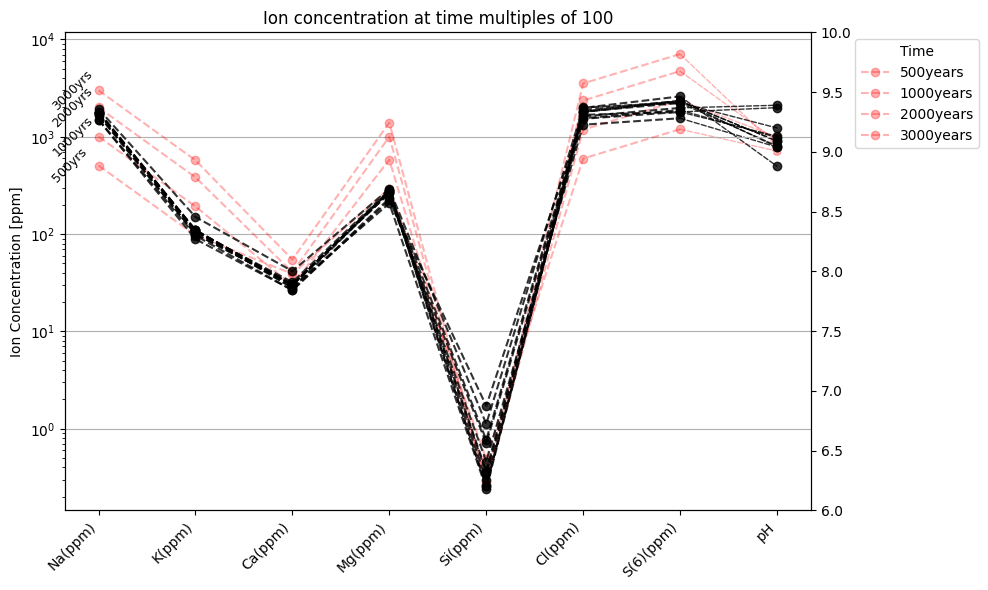

In [7]:
# Create data frame
evap_df = pd.DataFrame(result, columns=evap_header)
evap_df['Na(ppm)'] = evap_df['Na(mol/kgw)'] * 1000 * Na_molar_mass
evap_df['Cl(ppm)'] = evap_df['Cl(mol/kgw)'] * 1000 * Cl_molar_mass
evap_df['S(6)(ppm)'] = evap_df['S(6)(mol/kgw)'] * 1000 * SO4_molar_mass
evap_df['C(4)(ppm)'] = evap_df['C(4)(mol/kgw)'] * 1000 * HCO3_molar_mass
evap_df['K(ppm)'] = evap_df['K(mol/kgw)'] * 1000 * K_molar_mass
evap_df['Ca(ppm)'] = evap_df['Ca(mol/kgw)'] * 1000 * Ca_molar_mass
evap_df['Mg(ppm)'] = evap_df['Mg(mol/kgw)'] * 1000 * Mg_molar_mass
evap_df['Si(ppm)'] = evap_df['Si(mol/kgw)'] * 1000 * Si_molar_mass

# Lake Data
bts_df = pd.read_csv("lake_ion_data.csv", index_col='Site')

# Plot
fig1, axes = plt.subplots(
  nrows=4,
  ncols=1,
  figsize=(8, 24)
)

# pH plot
evap_df.plot(
  x="time",
  y="pH",
  ax=axes[0]
)
axes[0].set_xlim(0,Simulation_time)
axes[0].grid(True)
axes[0].set_xlabel('Time[yrs]')
axes[0].set_ylabel('pH')

# Ion concentration plot
evap_df.plot(
  x="time",
  y=[
    'Na(ppm)', 'K(ppm)', 'Ca(ppm)', 'Mg(ppm)',
    'Si(ppm)', 'Cl(ppm)', 'S(6)(ppm)', 'C(4)(ppm)'
],
  ax=axes[1]
)
axes[1].set_xlim(0,Simulation_time)
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].set_xlabel('Time [years]')
axes[1].set_ylabel('Ion Concentratino [ppm]')

# Mineral plot
evap_df.plot(
  x="time",
  y=['Monohydrocalcite','AMC_TK','MSH075KF'],
  ax=axes[2]
)
axes[2].set_yscale('log')
axes[2].set_xlim(0,Simulation_time)
axes[2].grid(True)
axes[2].set_xlabel('Time [years]')
axes[2].set_ylabel('Mineral precipitation per volume [mol/L]')

# Mineral delta plot
evap_df.plot(
  x="time",
  y=['d_Monohydrocalcite','d_AMC_TK','d_MSH075KF'],
  ax=axes[3]
)
axes[3].set_xlim(0,Simulation_time)
axes[3].set_ylim(bottom=0)
axes[3].grid(True)
axes[3].set_xlabel('Time [years]')
axes[3].set_ylabel('ΔMineral precipitation per volume [mol/(L*yr)]')


# Actibities plot
fig2, ax = plt.subplots()
ax.set_xlim(-7, -1)
ax.plot(
  np.array(ax.get_xlim()),
  -1 * np.array(ax.get_xlim()) - 7.65,
  label="MHC solubility",
  color="black"
)
ax.plot(
  np.array(ax.get_xlim()),
  -1 * np.array(ax.get_xlim()) - 5.59,
  label="AMC solubility",
  color="red"
)
evap_df.plot(
  x="la_Mg+2",
  y='la_CO3-2',
  ax=ax,
  label='Simulated log a Mg++'
)
evap_df.plot(
  x="la_Ca+2",
  y='la_CO3-2',
  ax=ax,
  label='Simulated log a Ca++'
)
bts_co3 = [-3.4156,-3.3305,-3.3314,-3.373,-3.179,-3.403,-3.4851,-3.4215,-3.3371,-3.1981,-3.5627]
bts_ca = [-3.8372,-3.8524,-3.8286,-3.8332,-3.8237,-3.7495,-3.6906,-3.8488,-3.8384,-3.8858,-3.7383]
bts_mg = [-2.5713,-2.6617,-2.5519,-2.5394,-2.5465,-2.4809,-2.5213,-2.5311,-2.544,-2.6292,-2.4795]
lake_co3 = [-1.8974,-1.5236,-1.4731,-1.5331,-3.1629,-2.9299,-3.2176,-2.5288,-1.963,-2.6524,-3.5523,-3.3685,-1.6666,-3.0702,-3.0149,-2.4073,-3.1938,-3.3534,-3.2415]
lake_ca = [-5.5268,-5.6001,-5.6367,-5.5375,-4.0314,-4.6758,-4.3135,-4.7231,-5.4706,-4.9997,-4.1116,-3.7092,-5.7446,-4.3776,-4.5156,-5.2079,-3.8298,-3.6535,-3.7797]
lake_mg = [-3.9425,-3.8091,-4.0922,-3.9199,-2.2201,-2.2418,-2.2313,-4.1216,-3.5911,-2.8206,-2.2463,-2.608,-4.2884,-2.55,-2.7685,-3.4032,-2.4768,-2.5176,-2.4096]
ax.scatter(
  bts_ca,
  bts_co3,
  s=50,
  marker="s",
  edgecolor="black",
  facecolor="none",
  alpha=0.7,
  label="BTS log a Ca++"
)
ax.scatter(
  lake_ca,
  lake_co3,
  s=50,
  marker="o",
  edgecolor="black",
  facecolor="none",
  alpha=0.5,
  label="Lake log a Ca++"
)
ax.scatter(
  bts_mg,
  bts_co3,
  s=50,
  marker="s",
  edgecolor="red",
  facecolor="none",
  alpha=0.7,
  label="BTS log a Mg++"
)
ax.scatter(
  lake_mg,
  lake_co3,
  s=50,
  marker="o",
  edgecolor="red",
  facecolor="none",
  alpha=0.5,
  label="Lake log a Mg++"
)
ax.grid(True)
ax.set_xlabel('log a Ca++ & log a Mg++')
ax.set_ylabel('log a CO3--')

# Ion conc plot 2
ion_cols = [
  'Na(ppm)','K(ppm)','Ca(ppm)','Mg(ppm)',
  'Si(ppm)','Cl(ppm)','S(6)(ppm)','pH'
]

desired = [0, 500, 1000, 2000, 3000]
mask = evap_df['time'].isin(desired)
df100 = evap_df.loc[mask, ['time'] + ion_cols].set_index('time')
x = np.arange(len(ion_cols))

fig3, ax = plt.subplots(figsize=(10, 6))
for t, row in df100.iterrows():
    y = row[ion_cols[:-1]].values
    ax.plot(
        x[:-1], y,
        linestyle='--',
        marker='o',
        label=f"{int(t)}years",
        color='red',
        alpha=0.3
    )
    x_end = x[0]
    y_end = y[0]
    ax.text(
        x_end - 0.5,
        y_end,
        f"{int(t)}yrs",
        va="center",
        fontsize=9,
        rotation=45
    )
ax.set_xticks(x)
ax.set_xticklabels(ion_cols, rotation=45, ha='right')
ax.set_ylabel("Ion Concentration [ppm]")
ax.set_title("Ion concentration at time multiples of 100")
ax.grid(axis='y')
ax.set_yscale('log')
ax.legend(title="Time", bbox_to_anchor=(1.05, 1), loc='upper left')

ax2 = ax.twinx()
for t, row in df100.iterrows():
    ax2.scatter(
        x[-1], row['pH'],
        linestyle='--',
        marker='o',
        color='red',
        alpha=0.3
    )

for t, row in df100.iterrows():
    # S(6) 점 데이터 좌표
    xyA = (x[-2], row['S(6)(ppm)'])
    # pH 점 데이터 좌표
    xyB = (x[-1], row['pH'])

    con = ConnectionPatch(
        xyA=xyA, coordsA="data", axesA=ax,   # 왼쪽 축(ax)의 data coords
        xyB=xyB, coordsB="data", axesB=ax2,  # 오른쪽 축(ax2)의 data coords
        linestyle="--", color="red", linewidth=1, alpha=0.3
    )
    ax.add_artist(con)

for site, row in bts_df.iterrows():
    # 5.1) 농도 시계열 (ion_cols[:-1])  
    y_meas = row[ion_cols[:-1]].values
    ax.plot(
        x[:-1], y_meas,
        linestyle='--',
        marker='o',
        color='black',
        alpha=0.8
    )
    # 5.3) pH 산포  
    ax2.scatter(
        x[-1],
        row['pH'],
        marker='o',
        color='black',
        alpha=0.8
    )
    # 5.4) S(6)(ppm) ↔ pH 연결선  
    con = ConnectionPatch(
        xyA=(x[-2], row['S(6)(ppm)']), coordsA="data", axesA=ax,
        xyB=(x[-1], row['pH']),         coordsB="data", axesB=ax2,
        linestyle="--", color="black", linewidth=1, alpha=0.8
    )
    ax.add_artist(con)
    ax2.set_ylim(6, 10)

plt.tight_layout()

plt.show()

evap_df.to_csv("simulation_output.csv")

In [8]:
from sklearn.metrics import r2_score

# 시뮬레이션 결과: time을 인덱스로
sim_df = evap_df.set_index("time")

records = []
for site, obs_row in bts_df.iterrows():
    # 관측치
    obs = obs_row[ion_cols].astype(float)
    # SSE 계산
    diffsq = (sim_df[ion_cols] - obs) ** 2
    sse    = diffsq.sum(axis=1)
    best_t = sse.idxmin()
    best_sim = sim_df.loc[best_t, ion_cols]

    # 이온별 절대/상대 오차
    abs_err = (best_sim - obs).abs()
    rel_err = abs_err / obs * 100

    # 결정계수 R²
    r2 = r2_score(obs, best_sim)

    # 결과 레코드 작성
    rec = {
        "Site": site,
        "BestTime": best_t,
        "SSE": float(sse.loc[best_t]),
        "RMSE": float(np.sqrt(sse.loc[best_t] / len(ion_cols))),
        "R2": float(r2)
    }
    for ion in ion_cols:
        rec[f"{ion} Δ(ppm)"] = float(abs_err[ion])
        rec[f"{ion} err(%)"] = float(rel_err[ion])
    records.append(rec)

# DataFrame으로 정리
result_df = pd.DataFrame(records).set_index("Site")

# 보기 편하게 포맷 지정
pd.options.display.float_format = "{:.2f}".format

print(result_df)

                  BestTime        SSE   RMSE   R2  Na(ppm) Δ(ppm)  \
Site                                                                
BTS01 May              944  717020.06 299.38 0.85          541.19   
BTS03 May             1280 1010710.65 355.44 0.88          646.53   
BTS01 June            1112 1026516.23 358.21 0.85          643.89   
BTS03 June            1152  909453.61 337.17 0.87          614.05   
BTS01 August          1153 1200926.21 387.45 0.83          613.06   
BTS02 August          1175 1015436.39 356.27 0.86          631.14   
BTS03 August          1157  929052.83 340.78 0.87          639.07   
BTS02 August 2nd       965 1127352.91 375.39 0.78          710.28   
BTS03 August 2nd       983  724196.04 300.87 0.86          512.35   
BTS02 October          956 1111944.58 372.82 0.78          808.85   
BTS03 October          843 1044436.84 361.32 0.74          821.76   

                  Na(ppm) err(%)  K(ppm) Δ(ppm)  K(ppm) err(%)  \
Site                                

In [9]:
# Run the PHREEQC
print("Running...")
try:
    iphreeqc.run_string(no_inflow_calc)
except Exception as e:
    print("Failed to execute PHREEQC:", e)

Running...


<Figure size 640x480 with 0 Axes>

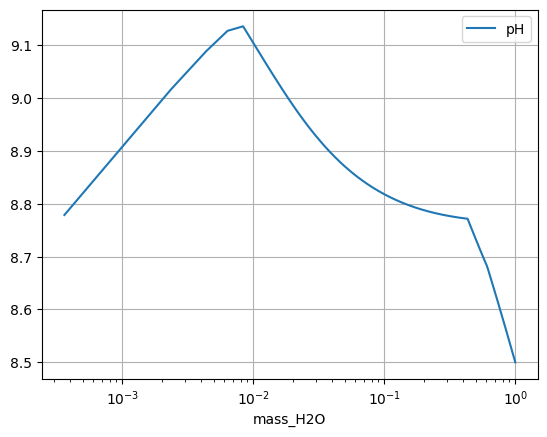

In [10]:
# Construct DataFrame
output = iphreeqc.get_selected_output_array()
header = output[0]
data = output[1:]
no_inflow_df = pd.DataFrame(data, columns=header)

plt.figure()
ph_plot = no_inflow_df.plot(x="mass_H2O", y="pH")
ph_plot.set_xscale('log')
plt.grid(True)

plt.show()